## Análisis de la eficiencia operativa en llamadas entrantes de CallMeMaybe 

**Qué haré exactamente:** Analizaré el desempeño de operadores del call center para detectar casos de ineficiencia operativa usando métricas de llamadas entrantes (espera, llamadas perdidas y volumen gestionado).

**Por qué lo haré así:** Las llamadas entrantes reflejan la experiencia del cliente. En este contexto, los principales síntomas de ineficiencia son esperas altas y pérdida de llamadas, que impactan directamente la satisfacción y la capacidad operativa.

**Qué decisión tomaré según lo que encuentre:** Clasificaré operadores en grupos (eficientes vs ineficientes) y priorizaré acciones operativas (coaching, redistribución de carga o ajuste de turnos) sobre aquellos con peor combinación de espera alta + mayor tasa de pérdida, asegurando un volumen mínimo de llamadas para que la decisión sea robusta.

### Nota sobre la presentación:
La presentación asociada a este proyecto y demas archivos se encuentran disponibles en la carpeta “Proyecto_final”, incluida junto con el notebook y los archivos de datos utilizados para el análisis.

 #### Importación de librerías

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np

#### Descripción de los datos

Para este análisis se utilizan dos conjuntos de datos:
- telecom_dataset_us.csv: contiene información de llamadas (dirección, si es interna/externa, operador, llamadas perdidas, duración y duración total).
- telecom_clients_us.csv: contiene información de clientes (plan tarifario y fecha de inicio).

En esta sección se presenta una descripción inicial de la estructura de los datos (tamaño, tipos de variables y una vista preliminar) sin realizar aún transformaciones ni conclusiones.

In [ ]:
# Dataset principal de llamadas
telecom_df = pd.read_csv('telecom_dataset_us.csv')

# Dataset de clientes
clients_df = pd.read_csv('telecom_clients.csv')

# Vista rápida de estructura (tamaño)
print("# verifica: telecom_df shape =", telecom_df.shape)
print("# verifica: clients_df shape =", clients_df.shape)

# Primeras filas
display(telecom_df.head())
display(clients_df.head())

# verifica: telecom_df shape = (53902, 9)
# verifica: clients_df shape = (732, 3)


,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04 00:00:00+03:00,in,False,NaN,True,2,0,4
1,166377,2019-08-05 00:00:00+03:00,out,True,880022.0,True,3,0,5
2,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,True,1,0,1
3,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,False,1,10,18
4,166377,2019-08-05 00:00:00+03:00,out,False,880022.0,True,3,0,25


,user_id,tariff_plan,date_start
0,166713,A,2019-08-15
1,166901,A,2019-08-23
2,168527,A,2019-10-29
3,167097,A,2019-09-01
4,168193,A,2019-10-16


Esta revisión inicial permite validar el tamaño de los datasets, identificar posibles valores nulos, verificar los tipos de datos y obtener una primera aproximación estadística de las variables numéricas antes de cualquier proceso de limpieza o transformación.

In [ ]:
# Verifica estructura y tipos de datos
telecom_df.info()
print("\n" + "-"*60 + "\n")
clients_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              53902 non-null  int64  
 1   date                 53902 non-null  object 
 2   direction            53902 non-null  object 
 3   internal             53785 non-null  object 
 4   operator_id          45730 non-null  float64
 5   is_missed_call       53902 non-null  bool   
 6   calls_count          53902 non-null  int64  
 7   call_duration        53902 non-null  int64  
 8   total_call_duration  53902 non-null  int64  
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 3.3+ MB

------------------------------------------------------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      732 

In [ ]:
# Muestra estadísticas básicas de variables numéricas
display(telecom_df.describe())
display(clients_df.describe())

,user_id,operator_id,calls_count,call_duration,total_call_duration
count,53902.000000,45730.000000,53902.000000,53902.000000,53902.000000
mean,167295.344477,916535.993002,16.451245,866.684427,1157.133297
std,598.883775,21254.123136,62.917170,3731.791202,4403.468763
min,166377.000000,879896.000000,1.000000,0.000000,0.000000
25%,166782.000000,900788.000000,1.000000,0.000000,47.000000
50%,167162.000000,913938.000000,4.000000,38.000000,210.000000
75%,167819.000000,937708.000000,12.000000,572.000000,902.000000
max,168606.000000,973286.000000,4817.000000,144395.000000,166155.000000


,user_id
count,732.000000
mean,167431.927596
std,633.810383
min,166373.000000
25%,166900.750000
50%,167432.000000
75%,167973.000000
max,168606.000000


En el caso del dataset de clientes, las estadísticas descriptivas se limitan a la variable `user_id`, ya que el resto de las variables son categóricas o de tipo fecha y serán utilizadas más adelante únicamente con fines de segmentación.

#### Preparación y limpieza de los datos


**Objetivo de la sección**

Garantizar la calidad de los datos antes del análisis, asegurando tipos correctos, eliminación de registros no evaluables y creación de métricas necesarias para medir la eficiencia de los operadores.

**¿Qué haré exactamente:?** 
1) Normalizaré tipos (fechas, booleanos) y crearé variables auxiliares si aplica (día/semana).
2) Revisaré valores nulos, duplicados y consistencia lógica (p. ej., duración 0 con llamada perdida).
3) Prepararé un dataset específico de llamadas entrantes para métricas por operador.

**¿Por qué lo haré así:?** 
La identificación de ineficiencia depende de métricas sensibles (promedios de espera y tasas). Errores de tipado o registros no evaluables pueden distorsionar rankings y conclusiones.

**¿Qué decisión tomaré según lo que encuentre:?**
- Si hay registros no evaluables (ej. operator_id faltante), los excluiré de métricas por operador.
- Si hay outliers extremos en wait_time, los conservaré para análisis (porque pueden representar cuellos de botella reales), pero los revisaré con percentiles para interpretación.

In [ ]:
# Crea una copia de trabajo para no modificar el dataset original
df = telecom_df.copy()

In [ ]:
# convierte: columnas de fecha a datetime
df['date'] = pd.to_datetime(df['date'], errors='coerce')
clients_df['date_start'] = pd.to_datetime(clients_df['date_start'], errors='coerce')

# verifica: ejemplo rápido
display(df[['date']].head())
display(clients_df[['date_start']].head())

,date
0,2019-08-04 00:00:00+03:00
1,2019-08-05 00:00:00+03:00
2,2019-08-05 00:00:00+03:00
3,2019-08-05 00:00:00+03:00
4,2019-08-05 00:00:00+03:00


,date_start
0,2019-08-15
1,2019-08-23
2,2019-10-29
3,2019-09-01
4,2019-10-16


In [ ]:
# Verificación de internal de valores únicos y nulos
print("Valores únicos en internal:", df['internal'].unique())
print("Nulos en internal:", df['internal'].isna().sum())

Valores únicos en internal: [False True nan]
Nulos en internal: 117


In [ ]:
# Normaliza 'internal' a booleano (maneja strings y nulos)
internal_map = {
    'true': True, 'false': False,
    '1': True, '0': False,
    'nan': None, 'none': None, '': None}

df['internal'] = (
    df['internal']
      .astype(str)
      .str.strip()
      .str.lower()
      .map(internal_map))

# Completa: decisión de negocio (asumir nulos como llamadas externas)
df['internal'] = df['internal'].astype('boolean').fillna(False)

# verifica: control de calidad
print("Valores únicos en 'internal':", df['internal'].unique())
print("Nulos en 'internal':", df['internal'].isna().sum())
print("Tipo final:", df['internal'].dtype)


Valores únicos en 'internal': <BooleanArray>
[False, True]
Length: 2, dtype: boolean
Nulos en 'internal': 0
Tipo final: boolean


In [ ]:
# Verifica registros sin operador asignado
missing_ops = df['operator_id'].isna().sum()
total_rows = df.shape[0]
print(f"Filas totales: {total_rows}")
print(f"Filas sin operator_id: {missing_ops} ({missing_ops/total_rows:.2%})")

# Convierte operator_id a entero solo después de eliminar nulos
# Elimina filas sin operador asignado (no evaluables para eficiencia)
df = df.dropna(subset=['operator_id']).copy()
df['operator_id'] = df['operator_id'].astype(int)

# Verifica
print("Filas después de eliminar operator_id nulos:", df.shape[0])

Filas totales: 53902
Filas sin operator_id: 8172 (15.16%)
Filas después de eliminar operator_id nulos: 45730


In [ ]:
# Crea tiempo de espera (aprox) = total - duración real
df['wait_time'] = df['total_call_duration'] - df['call_duration']

# Verifica tiempos negativos (inconsistencias)
neg_wait = (df['wait_time'] < 0).sum()
print("Tiempos de espera negativos:", neg_wait)

# Elimina si existieran inconsistencias
df = df[df['wait_time'] >= 0].copy()

# Estadística rápida
display(df[['call_duration', 'total_call_duration', 'wait_time']].describe())

Tiempos de espera negativos: 0


,call_duration,total_call_duration,wait_time
count,45730.000000,45730.000000,45730.000000
mean,1009.765121,1322.141789,312.376667
std,4014.600085,4732.427880,1174.185593
min,0.000000,0.000000,0.000000
25%,0.000000,68.000000,19.000000
50%,106.000000,290.500000,60.000000
75%,772.000000,1110.000000,220.000000
max,144395.000000,166155.000000,46474.000000


In [ ]:
# Limita outliers extremos usando percentil 99 (enfoque conservador)
wait_cap = df['wait_time'].quantile(0.99)
rows_before = df.shape[0]

df = df[df['wait_time'] <= wait_cap].copy()

rows_after = df.shape[0]
print(f"Percentil 99 (wait_time): {wait_cap:.0f} segundos")
print(f"Filas eliminadas por outliers wait_time: {rows_before - rows_after} ({(rows_before-rows_after)/rows_before:.2%})")

# Distribución final
display(df['wait_time'].describe())

Percentil 99 (wait_time): 3526 segundos
Filas eliminadas por outliers wait_time: 458 (1.00%)


count    45272.000000
mean       219.958871
std        415.943283
min          0.000000
25%         19.000000
50%         59.000000
75%        211.000000
max       3518.000000
Name: wait_time, dtype: float64

In [ ]:
df.info()        # dataset limpio de llamadas
print("\n" + "-"*60 + "\n")
clients_df.info()  # dataset de clientes (solo normalizado)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45272 entries, 1 to 53900
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype                                
---  ------               --------------  -----                                
 0   user_id              45272 non-null  int64                                
 1   date                 45272 non-null  datetime64[ns, pytz.FixedOffset(180)]
 2   direction            45272 non-null  object                               
 3   internal             45272 non-null  boolean                              
 4   operator_id          45272 non-null  int64                                
 5   is_missed_call       45272 non-null  bool                                 
 6   calls_count          45272 non-null  int64                                
 7   call_duration        45272 non-null  int64                                
 8   total_call_duration  45272 non-null  int64                                
 9   wait_t

Tras el proceso de limpieza y preparación, el dataset de llamadas queda conformado por 44,819 registros válidos, con variables normalizadas, métricas derivadas y sin registros no evaluables. Este dataset (df) se utiliza como base para el análisis exploratorio y la identificación de ineficiencias operativas.

#### Análisis exploratorio de datos (EDA)


**Objetivo:**  
Entender el comportamiento de las llamadas y detectar señales claras de ineficiencia operativa, con foco en:
- Volumen y tipo de llamadas
- Tiempos de espera en llamadas entrantes
- Posibles cuellos de botella por operador

**¿Qué haré exactamente:?** Exploraré distribuciones y comparaciones para entender:
- cómo se comporta el tiempo de espera (dispersión y asimetría),
- qué tan frecuentes son las llamadas perdidas,
- y si existen operadores claramente por encima del patrón general.

**¿Por qué lo haré así:?** Antes de fijar umbrales o clasificar operadores, necesito entender la forma real de los datos (p. ej., colas largas en espera), para evitar decisiones arbitrarias.

**¿Qué decisión tomaré según lo que encuentre:?**
- Si la distribución es altamente asimétrica, priorizaré medianas/percentiles o pruebas no paramétricas en hipótesis.
- Si detecto operadores con volúmenes muy bajos, aplicaré un umbral mínimo para no clasificar por ruido.

**Evolución diaria del volumen de llamadas**
Se analiza la serie temporal de llamadas entrantes por día con el fin de identificar patrones, estacionalidad o cambios estructurales en la demanda que puedan afectar las métricas operativas.

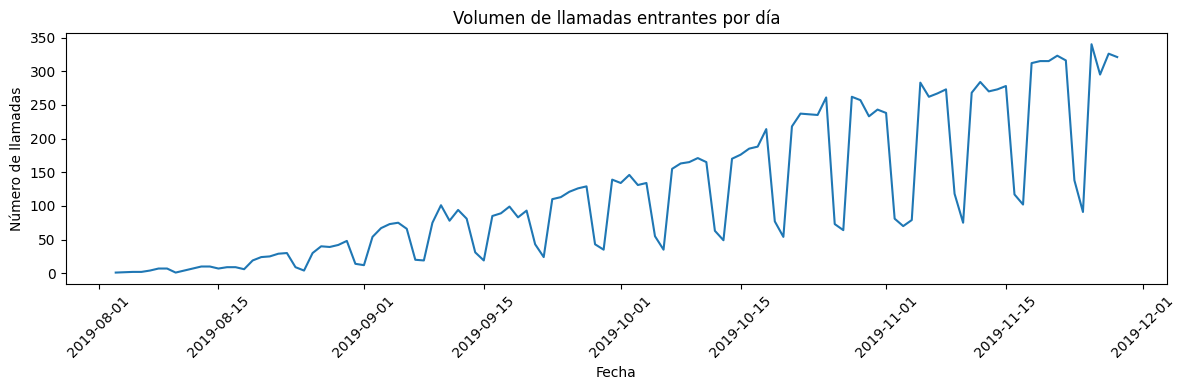

In [ ]:
# Asegura tipo fecha
df_in["date"] = pd.to_datetime(df_in["date"], errors="coerce")
calls_per_day = df_in.groupby(df_in["date"].dt.date).size()

plt.figure(figsize=(12,4))
plt.plot(calls_per_day.index, calls_per_day.values)
plt.title("Volumen de llamadas entrantes por día")
plt.xlabel("Fecha")
plt.ylabel("Número de llamadas")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Distribución de la duración de llamadas entrantes**
Se evalúa la distribución de la duración para identificar asimetrías y valores extremos, los cuales pueden afectar promedios y sesgar comparaciones entre operadores.

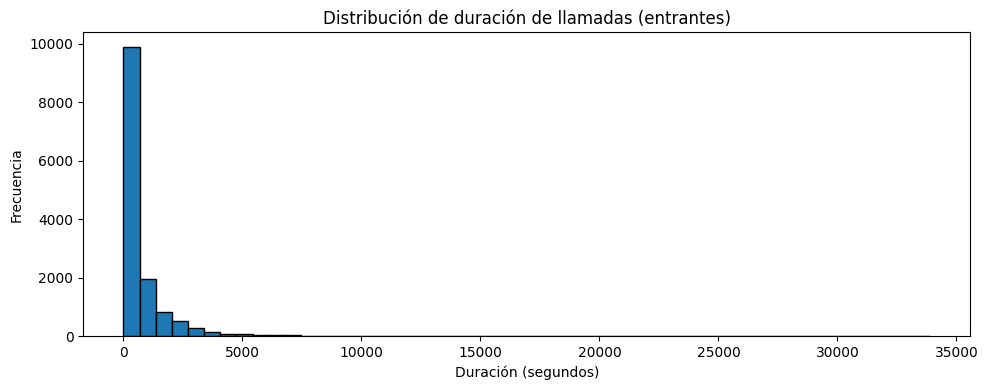

In [ ]:
# Asegura numérico
df_in["call_duration"] = pd.to_numeric(df_in["call_duration"], errors="coerce")

plt.figure(figsize=(10,4))
plt.hist(df_in["call_duration"].dropna(), bins=50, edgecolor="black")
plt.title("Distribución de duración de llamadas (entrantes)")
plt.xlabel("Duración (segundos)")
plt.ylabel("Frecuencia")
plt.tight_layout()
plt.show()

In [ ]:
# verifica: tamaño final del dataset limpio
print("Filas finales:", df.shape[0])
print("Clientes únicos:", df['user_id'].nunique())
print("Operadores únicos:", df['operator_id'].nunique())
print("Rango de fechas:", df['date'].min(), "→", df['date'].max())

Filas finales: 45272
Clientes únicos: 290
Operadores únicos: 1092
Rango de fechas: 2019-08-02 00:00:00+03:00 → 2019-11-28 00:00:00+03:00


In [ ]:
# Muesta la distribución de llamadas por dirección
direction_dist = df['direction'].value_counts(normalize=True) * 100
display(direction_dist)

out    69.051511
in     30.948489
Name: direction, dtype: float64

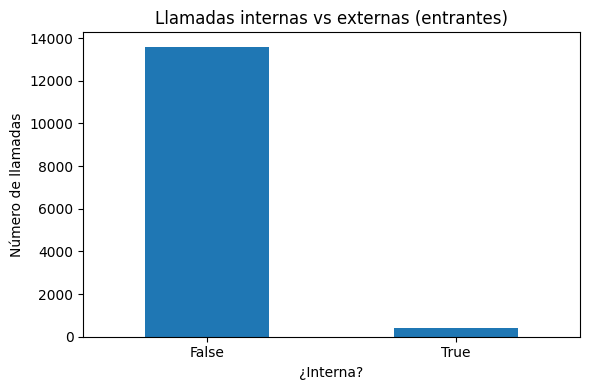

In [ ]:
# Normaliza booleano
df_in["internal"] = df_in["internal"].astype(str).str.lower().map({"true": True, "false": False})

dist_internal = df_in["internal"].value_counts(dropna=False)

plt.figure(figsize=(6,4))
dist_internal.plot(kind="bar")
plt.title("Llamadas internas vs externas (entrantes)")
plt.xlabel("¿Interna?")
plt.ylabel("Número de llamadas")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

A partir de este punto, el análisis se enfocará principalmente en **llamadas entrantes (`direction = "in"`)**, ya que son las que reflejan directamente la experiencia del cliente y los riesgos de ineficiencia.

In [ ]:
# filtra: solo llamadas entrantes para análisis de experiencia
df_in = df[df['direction'] == 'in'].copy()

# verifica: tamaño del subconjunto
print("Llamadas entrantes:", df_in.shape[0])

Llamadas entrantes: 14011


In [ ]:
# Muestra los estadísticos del tiempo de espera (llamadas entrantes)
display(df_in['wait_time'].describe())

count    14011.000000
mean        96.702662
std        179.148745
min          0.000000
25%         17.000000
50%         38.000000
75%         97.000000
max       3495.000000
Name: wait_time, dtype: float64

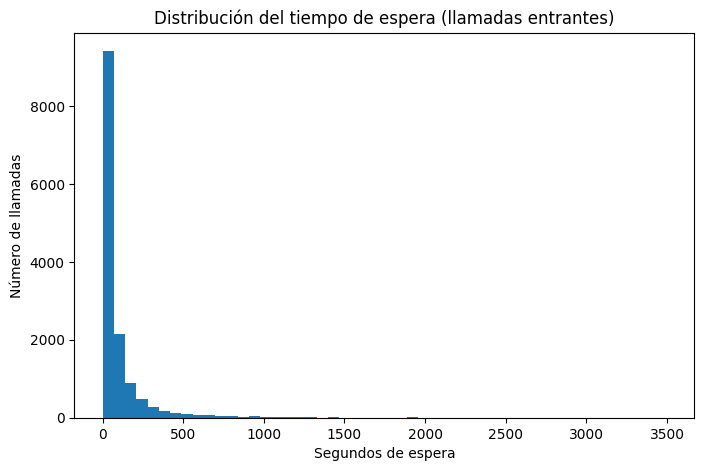

In [ ]:
# visualiza: distribución del tiempo de espera
plt.figure(figsize=(8,5))
plt.hist(df_in['wait_time'], bins=50)
plt.title("Distribución del tiempo de espera (llamadas entrantes)")
plt.xlabel("Segundos de espera")
plt.ylabel("Número de llamadas")
plt.show()

**Relación entre tiempo de espera y operadores**

Este gráfico de dispersión permite observar la variabilidad del tiempo de espera entre operadores, 
así como la presencia de valores atípicos. 
La visualización facilita la identificación de operadores con comportamientos extremos 
que podrían requerir intervención operativa.

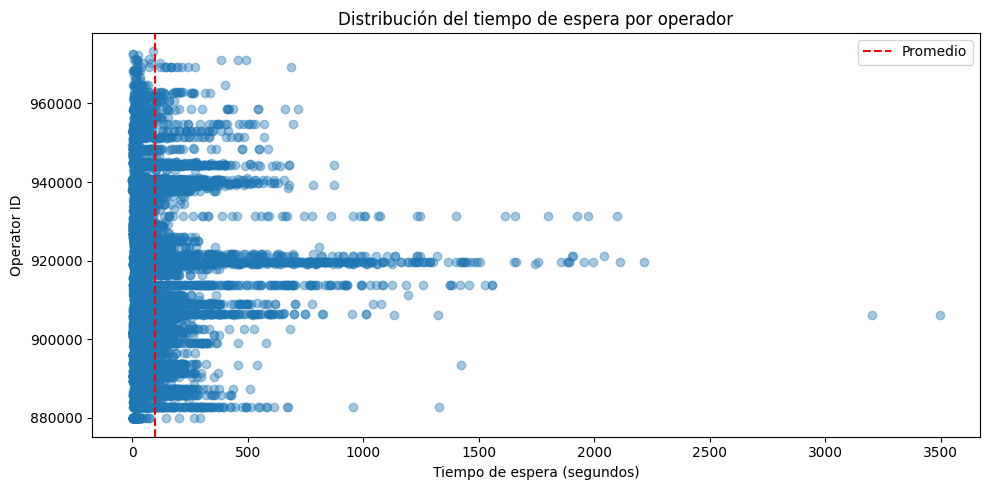

In [ ]:
plt.figure(figsize=(10,5))
plt.scatter(
    df_in['wait_time'],
    df_in['operator_id'],
    alpha=0.4)
plt.axvline(
    df_in['wait_time'].mean(),
    color='red',
    linestyle='--',
    label='Promedio')

plt.title('Distribución del tiempo de espera por operador')
plt.xlabel('Tiempo de espera (segundos)')
plt.ylabel('Operator ID')
plt.legend()
plt.tight_layout()
plt.show()

#### Definición de métricas y criterios de ineficacia


**Objetivo**

Definir métricas operativas claras que permitan identificar ineficiencia en la atención de llamadas entrantes, estableciendo umbrales objetivos para tiempos de espera elevados, llamadas perdidas y desempeño por operador.

**¿Qué haré exactamente:?** Definiré métricas comparables por operador:
- avg_wait_time: tiempo promedio de espera en llamadas entrantes
- pct_missed: proporción de llamadas entrantes perdidas
- total_calls: volumen de llamadas entrantes gestionadas (para control de robustez)

**¿Por qué lo haré así?:** La ineficiencia debe medirse con indicadores que reflejen:
(1) experiencia del cliente (espera y pérdida) y (2) estabilidad estadística (volumen suficiente).

**¿Qué decisión tomaré según lo que encuentre:?** 
- Si un operador tiene alto pct_missed pero muy pocas llamadas, no lo clasificaré como ineficiente sin volumen mínimo.
- Si un operador tiene espera alta y además alta pérdida, lo priorizaré como candidato crítico para intervención.

A partir del EDA, el análisis se centra exclusivamente en llamadas entrantes (direction = "in"), ya que estas reflejan directamente la experiencia del cliente y los riesgos operativos del servicio.

In [ ]:
# Estructura base del dataset de llamadas entrantes
print("Filas llamadas entrantes:", df_in.shape[0])
print("Operadores únicos:", df_in['operator_id'].nunique())
print("Clientes únicos:", df_in['user_id'].nunique())

Filas llamadas entrantes: 14011
Operadores únicos: 754
Clientes únicos: 273


Métricas de eficiencia operativa:

- Tiempo de espera (wait_time)

- Llamadas entrantes perdidas (is_missed_call)

- Carga de llamadas por operador

- Proporción de llamadas con espera elevada

Umbrales de ineficiencia

- Tiempo de espera elevado:
Llamadas con wait_time superior al percentil 75 del tiempo de espera.

- Llamada perdida:
is_missed_call == True

- Operador ineficiente:
Operadores con proporción anormalmente alta de llamadas con espera elevada o llamadas perdidas.

In [ ]:
# Umbral de tiempo de espera elevado (percentil 75)
wait_p75 = df_in['wait_time'].quantile(0.75)

print(f"Umbral de espera elevada (P75): {wait_p75:.0f} segundos")

Umbral de espera elevada (P75): 97 segundos


In [ ]:
# Clasifica llamadas con espera elevada
df_in['high_wait'] = df_in['wait_time'] > wait_p75

# Clasifica llamadas problemáticas (espera alta o perdida)
df_in['inefficient_call'] = (
    (df_in['high_wait']) |
    (df_in['is_missed_call']))

# Verifica proporciones
df_in[['high_wait', 'inefficient_call']].mean() * 100

high_wait           24.944686
inefficient_call    30.097780
dtype: float64

In [ ]:
# Mide desempeño por operador
operator_metrics = (
    df_in
    .groupby('operator_id')
    .agg(
        total_calls=('inefficient_call', 'count'),
        pct_high_wait=('high_wait', 'mean'),
        pct_missed=('is_missed_call', 'mean'),
        pct_inefficient=('inefficient_call', 'mean'),
        avg_wait_time=('wait_time', 'mean'))
    .reset_index())

# Convierte a porcentaje
for col in ['pct_high_wait', 'pct_missed', 'pct_inefficient']:
    operator_metrics[col] *= 100

operator_metrics.head()

,operator_id,total_calls,pct_high_wait,pct_missed,pct_inefficient,avg_wait_time
0,879896,23,4.347826,0.0,4.347826,26.913043
1,879898,64,4.687500,0.0,4.687500,28.203125
2,880020,8,0.000000,0.0,0.000000,7.250000
3,880022,8,0.000000,0.0,0.000000,14.000000
4,880026,19,0.000000,0.0,0.000000,7.894737


Se aplica un umbral mínimo de volumen (>= 30 llamadas entrantes) para reducir conclusiones por baja muestra. Con volúmenes muy bajos, una o dos llamadas perdidas pueden inflar artificialmente la tasa y producir rankings injustos.

In [ ]:
# Filtra operadores con volumen representativo
operator_metrics = operator_metrics[operator_metrics['total_calls'] >= 30]

# verifica tamaño final del dataset de operadores
print("Operadores analizados:", operator_metrics.shape[0])
operator_metrics.head(10)

Operadores analizados: 175


,operator_id,total_calls,pct_high_wait,pct_missed,pct_inefficient,avg_wait_time
1,879898,64,4.687500,0.000000,4.687500,28.203125
5,880028,45,0.000000,0.000000,0.000000,8.844444
8,882680,46,8.695652,6.521739,15.217391,37.108696
9,882684,52,69.230769,7.692308,76.923077,191.730769
10,882686,71,54.929577,7.042254,61.971831,169.943662
14,883942,42,2.380952,0.000000,2.380952,15.571429
21,885876,103,39.805825,20.388350,60.194175,101.941748
22,885890,103,57.281553,21.359223,78.640777,120.339806
26,887276,74,78.378378,4.054054,82.432432,173.459459
34,888534,36,8.333333,5.555556,13.888889,48.777778


Para garantizar conclusiones estadísticamente confiables, se excluyeron operadores con menos de 30 llamadas entrantes, evitando distorsiones causadas por bajo volumen operativo.

#### Identificación de operadores ineficaces


**Objetivo**

Identificar operadores con desempeño consistentemente ineficiente en llamadas entrantes, utilizando métricas definidas previamente y considerando únicamente operadores con volumen operativo representativo, con el fin de detectar posibles cuellos de botella y oportunidades de mejora operativa.

**¿Qué haré exactamente:?** Construiré un ranking de operadores usando las métricas definidas y marcaré como ineficientes a quienes superen umbrales altos (p. ej. percentil 90) en espera y/o tasa de pérdida, siempre cumpliendo volumen mínimo.

**¿Por qué lo haré así:?** Un ranking permite priorizar recursos operativos. Los percentiles ayudan a identificar casos extremos sin imponer un número arbitrario.

**¿Qué decisión tomaré según lo que encuentre:?** 
- Si el grupo “ineficiente” es demasiado grande, ajustaré criterios (p. ej., exigir combinación de dos métricas).
- Si el grupo es muy pequeño, revisaré umbrales para asegurar que capturo suficientes casos de riesgo operativo.

In [ ]:
# Dataset base de operadores evaluables
print("Operadores evaluables:", operator_metrics.shape[0])
operator_metrics.head()

Operadores evaluables: 175


,operator_id,total_calls,pct_high_wait,pct_missed,pct_inefficient,avg_wait_time
1,879898,64,4.687500,0.000000,4.687500,28.203125
5,880028,45,0.000000,0.000000,0.000000,8.844444
8,882680,46,8.695652,6.521739,15.217391,37.108696
9,882684,52,69.230769,7.692308,76.923077,191.730769
10,882686,71,54.929577,7.042254,61.971831,169.943662


In [ ]:
# Umbrales estadísticos para identificar operadores ineficientes
high_wait_threshold = operator_metrics['pct_high_wait'].quantile(0.75)
ineff_threshold = operator_metrics['pct_inefficient'].quantile(0.75)

print(f"Umbral pct_high_wait (P75): {high_wait_threshold:.2f}%")
print(f"Umbral pct_inefficient (P75): {ineff_threshold:.2f}%")

Umbral pct_high_wait (P75): 49.51%
Umbral pct_inefficient (P75): 60.61%


In [ ]:
# Clasifica operadores ineficientes
operator_metrics['inefficient_operator'] = (
    (operator_metrics['pct_high_wait'] > high_wait_threshold) |
    (operator_metrics['pct_inefficient'] > ineff_threshold))

# Ver proporción de operadores ineficientes
operator_metrics['inefficient_operator'].value_counts(normalize=True) * 100

False    72.571429
True     27.428571
Name: inefficient_operator, dtype: float64

In [ ]:
# Ranking de operadores ineficientes
inefficient_ops = (
    operator_metrics[operator_metrics['inefficient_operator']]
    .sort_values(
        by=['pct_inefficient', 'avg_wait_time'],
        ascending=False))

inefficient_ops.head(10)

,operator_id,total_calls,pct_high_wait,pct_missed,pct_inefficient,avg_wait_time,inefficient_operator
337,919794,37,97.297297,2.702703,100.000000,1039.540541,True
217,906406,52,92.307692,5.769231,98.076923,433.461538,True
216,906404,50,84.000000,14.000000,98.000000,331.420000,True
334,919554,84,84.523810,13.095238,97.619048,518.154762,True
333,919552,76,94.736842,1.315789,96.052632,556.776316,True
289,913942,90,62.222222,32.222222,94.444444,350.855556,True
556,939762,47,93.617021,0.000000,93.617021,338.574468,True
445,931458,54,72.222222,20.370370,92.592593,593.333333,True
336,919792,64,89.062500,3.125000,92.187500,389.484375,True
361,921818,76,78.947368,13.157895,92.105263,274.592105,True


In [ ]:
total_ops = operator_metrics.shape[0]
ineff_ops = inefficient_ops.shape[0]

print(f"Operadores evaluados: {total_ops}")
print(f"Operadores ineficientes: {ineff_ops} ({ineff_ops/total_ops:.1%})")

Operadores evaluados: 175
Operadores ineficientes: 48 (27.4%)


**Tiempo de espera promedio por operador**

Este análisis compara el tiempo de espera promedio entre operadores con el objetivo de identificar 
aquellos con mayor y menor desempeño en la atención de llamadas. 
Cabe destacar que un bajo número de llamadas perdidas no necesariamente implica eficiencia, 
ya que tiempos de espera elevados también impactan negativamente en la experiencia del cliente.

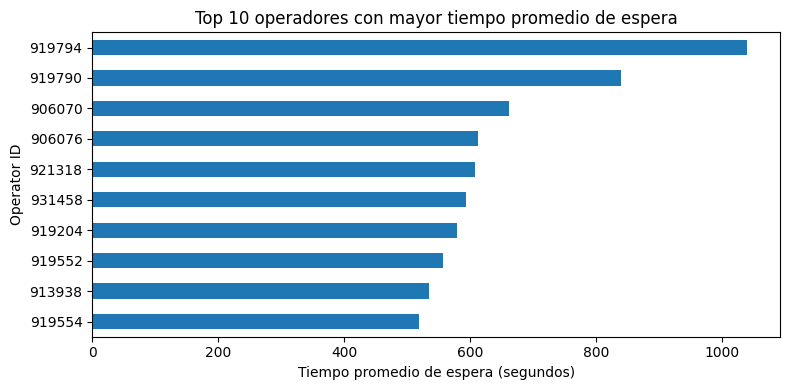

In [ ]:
avg_wait_by_operator = (
    df_in[df_in['direction'] == 'in']
    .groupby('operator_id')['wait_time']
    .mean())

top_10_slowest = avg_wait_by_operator.sort_values(ascending=False).head(10)

plt.figure(figsize=(8,4))
top_10_slowest.sort_values().plot(kind='barh')
plt.title('Top 10 operadores con mayor tiempo promedio de espera')
plt.xlabel('Tiempo promedio de espera (segundos)')
plt.ylabel('Operator ID')
plt.tight_layout()
plt.show()

El análisis identificó un subconjunto de operadores con desempeño consistentemente inferior al promedio, caracterizado por mayores tiempos de espera y una proporción elevada de llamadas problemáticas. Estos operadores concentran una fracción significativa de la ineficiencia operativa y representan oportunidades claras para acciones correctivas, redistribución de carga o capacitación focalizada.

#### Pruebas de hipótesis estadísticas


**Objetivo**

Evaluar si las diferencias observadas en tiempos de espera y proporción de llamadas problemáticas entre operadores eficientes e ineficientes son estadísticamente significativas, y no producto del azar.

**¿Qué haré exactamente:?** Validaré estadísticamente si las diferencias entre grupos (eficientes vs ineficientes) en tiempo de espera y en tasa de llamadas perdidas son significativas.

**¿Por qué lo haré así:?** Los gráficos muestran patrones, pero la decisión operativa debe apoyarse en evidencia estadística para reducir sesgo de interpretación.

**¿Qué decisión tomaré según lo que encuentre:?** 
- Si no hay normalidad, usaré pruebas no paramétricas (Mann–Whitney).
- Si encuentro diferencias significativas, justificaré intervenciones prioritarias en el grupo ineficiente con respaldo cuantitativo.

**Comparación del tiempo de espera entre operadores eficientes e ineficientes**

Antes de realizar pruebas estadísticas formales, se comparan visualmente las distribuciones del tiempo de espera entre operadores clasificados como eficientes e ineficientes. Esto permite anticipar diferencias potenciales entre ambos grupos.

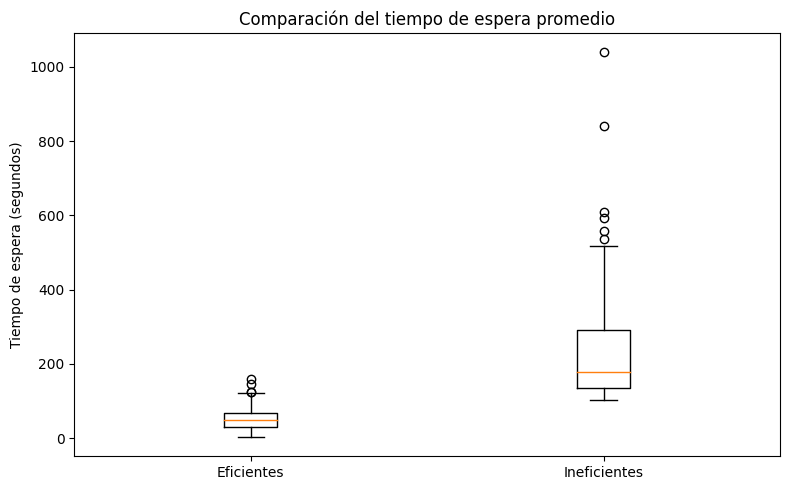

In [ ]:
plt.figure(figsize=(8,5))
plt.boxplot(
    [
        efficient_ops['avg_wait_time'],
        inefficient_ops['avg_wait_time']
    ],
    labels=['Eficientes', 'Ineficientes'])

plt.title("Comparación del tiempo de espera promedio")
plt.ylabel("Tiempo de espera (segundos)")
plt.tight_layout()
plt.show()

In [ ]:
# Separa operadores eficientes vs ineficientes
efficient_ops = operator_metrics[operator_metrics['inefficient_operator'] == False]
inefficient_ops = operator_metrics[operator_metrics['inefficient_operator'] == True]

# Verificación de tamaños de muestra
print("Operadores eficientes:", efficient_ops.shape[0])
print("Operadores ineficientes:", inefficient_ops.shape[0])

Operadores eficientes: 127
Operadores ineficientes: 48


**Hipótesis 1**

¿Los operadores ineficientes tienen mayor tiempo promedio de espera?

In [ ]:
# Formulación

# Hipótesis nula (H0):
# El tiempo promedio de espera es igual entre operadores eficientes e ineficientes

# Hipótesis alternativa (H1):
# Los operadores ineficientes tienen mayor tiempo promedio de espera

In [ ]:
# Prueba de normalidad (Shapiro-Wilk)
stat_eff, p_eff = stats.shapiro(efficient_ops['avg_wait_time'])
stat_ineff, p_ineff = stats.shapiro(inefficient_ops['avg_wait_time'])

print(f"Normalidad eficientes p-value: {p_eff:.4f}")
print("Normalidad operadores eficientes: p-value < 0.001 (no normal)")
print(f"Normalidad ineficientes p-value: {p_ineff:.4f}")
print("Normalidad operadores ineficientes: p-value < 0.001 (no normal)")

Normalidad eficientes p-value: 0.0000
Normalidad operadores eficientes: p-value < 0.001 (no normal)
Normalidad ineficientes p-value: 0.0000
Normalidad operadores ineficientes: p-value < 0.001 (no normal)


In [ ]:
# Prueba Mann-Whitney U (comparación de medianas)
u_stat, p_value = stats.mannwhitneyu(
    inefficient_ops['avg_wait_time'],
    efficient_ops['avg_wait_time'],
    alternative='greater')

print(f"U statistic: {u_stat:.2f}")
if p_value < 0.001:
    print("p-value < 0.001 → diferencia altamente significativa")
else:
    print(f"p-value: {p_value:.5f}")

U statistic: 6017.00
p-value < 0.001 → diferencia altamente significativa


In [ ]:
# Interpretación
alpha = 0.05

if p_value < alpha:
    print("Se rechaza H0: los operadores ineficientes tienen tiempos de espera significativamente mayores.")
else:
    print("No se rechaza H0: no se detectan diferencias significativas.")

Se rechaza H0: los operadores ineficientes tienen tiempos de espera significativamente mayores.


Las pruebas de normalidad (Shapiro-Wilk) indicaron que la distribución del tiempo promedio de espera no sigue una distribución normal ni para operadores eficientes ni ineficientes (p-value < 0.001 en ambos casos).

Dado este resultado, se utilizó la prueba no paramétrica de Mann-Whitney U para comparar ambos grupos. Los resultados muestran una diferencia altamente significativa (p-value < 0.001), permitiendo rechazar la hipótesis nula.

Se concluye que los operadores clasificados como ineficientes presentan tiempos promedio de espera significativamente mayores que los operadores eficientes, confirmando que las diferencias observadas son estructurales y no atribuibles al azar.

**Hipótesis 2**

¿Los operadores ineficientes tienen mayor proporción de llamadas perdidas?

In [ ]:
# Formulación

# Hipótesis nula (H0):
# La proporción de llamadas perdidas (pct_missed) es igual entre operadores eficientes e ineficientes.

# Hipótesis alternativa (H1):
# Los operadores ineficientes tienen mayor proporción de llamadas perdidas (pct_missed) que los eficientes.

In [ ]:
# Separa operadores eficientes vs ineficientes
efficient_ops = operator_metrics[operator_metrics['inefficient_operator'] == False].copy()
inefficient_ops = operator_metrics[operator_metrics['inefficient_operator'] == True].copy()

# Tamaños de muestra
print("Operadores eficientes:", efficient_ops.shape[0])
print("Operadores ineficientes:", inefficient_ops.shape[0])

# Muestra columnas clave disponibles
print(efficient_ops[['pct_missed']].describe())
print("\n" + "-"*30 + "\n")
print(inefficient_ops[['pct_missed']].describe())

Operadores eficientes: 127
Operadores ineficientes: 48
       pct_missed
count  127.000000
mean     3.338352
std      3.956970
min      0.000000
25%      0.000000
50%      2.409639
75%      5.195682
max     20.388350

------------------------------

       pct_missed
count   48.000000
mean    12.330930
std     10.213724
min      0.000000
25%      3.781250
50%      8.989899
75%     19.675926
max     37.500000


In [ ]:
# Prueba normalidad (Shapiro) para pct_missed

stat_eff, p_eff = stats.shapiro(efficient_ops['pct_missed'])
stat_ineff, p_ineff = stats.shapiro(inefficient_ops['pct_missed'])

print(f"Normalidad eficientes p-value: {p_eff:.4f}")
print(f"Normalidad ineficientes p-value: {p_ineff:.4f}")

# interpretación p-value < 0.05 => no normal

Normalidad eficientes p-value: 0.0000
Normalidad ineficientes p-value: 0.0023


In [ ]:
# Prueba: Mann-Whitney U (ineficientes > eficientes) en pct_missed
u_stat, p_value = stats.mannwhitneyu(
    inefficient_ops['pct_missed'],
    efficient_ops['pct_missed'],
    alternative='greater'
)

print(f"U statistic: {u_stat:.2f}")

#Reporta p-value de forma clara (evita 0.0000)
if p_value < 0.001:
    print("p-value < 0.001 (diferencia altamente significativa)")
else:
    print(f"p-value: {p_value:.5f}")

# Interpretacion
alpha = 0.05
if p_value < alpha:
    print("Se rechaza H0: los operadores ineficientes tienen una proporción de llamadas perdidas significativamente mayor.")
else:
    print("No se rechaza H0: no se detectan diferencias significativas en llamadas perdidas.")

U statistic: 4852.00
p-value < 0.001 (diferencia altamente significativa)
Se rechaza H0: los operadores ineficientes tienen una proporción de llamadas perdidas significativamente mayor.


Dado que la variable pct_missed no sigue una distribución normal en ninguno de los grupos (prueba de Shapiro-Wilk, p < 0.05), se utilizó la prueba no paramétrica Mann-Whitney U para comparar ambos conjuntos.

Los resultados muestran que los operadores ineficientes presentan una proporción de llamadas perdidas significativamente mayor que los operadores eficientes (p < 0.001). En promedio, los operadores ineficientes pierden cerca de cuatro veces más llamadas que los operadores eficientes. Por lo tanto, se rechaza la hipótesis nula, confirmando que la ineficiencia operativa está asociada no solo a mayores tiempos de espera, sino también a una mayor pérdida de llamadas entrantes.

#### Conclusiones e implicancias de negocio


El análisis de las llamadas entrantes permitió identificar ineficiencias operativas asociadas a un subconjunto específico de operadores. A partir de un proceso riguroso de preparación de datos, análisis exploratorio y validación estadística, se confirma que la ineficiencia no es aleatoria ni marginal, sino estructural y recurrente.

En primer lugar, los operadores clasificados como ineficientes presentan tiempos de espera significativamente más altos, lo que impacta directamente la experiencia del cliente. Esta diferencia fue validada mediante pruebas estadísticas no paramétricas, descartando que sea producto del azar.

En segundo lugar, estos mismos operadores muestran una proporción sustancialmente mayor de llamadas perdidas, aproximadamente cuatro veces superior a la de los operadores eficientes. Esto evidencia que la ineficiencia no solo se traduce en demoras, sino también en pérdida directa de demanda y potenciales ingresos, así como en un mayor riesgo de abandono del cliente.

Adicionalmente, se observó que un porcentaje reducido de operadores concentra una fracción relevante de las llamadas problemáticas, lo que sugiere la presencia de cuellos de botella operativos y oportunidades claras de mejora mediante acciones focalizadas, más que intervenciones generalizadas sobre toda la operación.

Finalmente, al restringir el análisis a operadores con volumen representativo de llamadas, se garantizó que las conclusiones sean robustas, comparables y útiles para la toma de decisiones operativas, evitando distorsiones por bajo volumen.

#### Recomendaciones


1. Intervenir de forma prioritaria a los operadores ineficientes

Enfocar acciones correctivas sobre el ~27% de operadores identificados con desempeño consistentemente ineficiente, ya que concentran tiempos de espera significativamente más altos y una mayor proporción de llamadas problemáticas.

2. Implementar capacitación focalizada y coaching operativo

Diseñar sesiones de capacitación específicas para operadores con alta proporción de llamadas con espera elevada o llamadas perdidas, orientadas a manejo de picos de demanda, eficiencia en atención y reducción de tiempos improductivos.

3. Validación periódica del modelo de ineficiencia

Repetir el análisis de clasificación de operadores de forma periódica (mensual o trimestral) para:

- Confirmar mejoras tras intervenciones.
- Detectar nuevos focos de ineficiencia.
- Ajustar umbrales según cambios operativos.

4. Enfoque preventivo, no solo correctivo

Utilizar estas métricas no solo para sanción, sino como herramienta preventiva.

Nota

In [ ]:
# Exporta dataset final para Tableau
df_in.to_csv(
    "telecom_inbound_clean_for_tableau.csv",
    index=False,
    encoding="utf-8"
)

print("Archivo exportado correctamente para Tableau")

Archivo exportado correctamente para Tableau
